In [77]:
import sys
import os
from dotenv import load_dotenv

#1. load environment variables and data

# load environment variables
load_dotenv()

#add working directory to sys path to execute utils/dataset.py
working_dir = os.environ.get("WORKING_DIRECTORY")
sys.path.insert(0, working_dir)

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.dataset import get_data 
df = get_data()
df.head(10)

Loading data from wines: 8000it [00:00, 18450.32it/s]


,wine type,fixed acidity,volatile acidity,citric acid,residual sugar,magnesium,flavanoids,minerals,calcium,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,Pinot noir,5.8,0.15,0.49,1.1,76.729301,894.94,186.639301,109.91,0.048,21.0,98.0,0.99290,3.19,0.48,9.2,5
1,Merlot,6.6,0.25,0.32,5.6,4.795712,1160.95,251.875712,247.08,0.039,15.0,68.0,0.99163,2.96,0.52,11.1,6
2,Chardonnay,6.7,0.21,0.34,1.5,85.193710,789.82,304.703710,219.51,0.035,45.0,123.0,0.98949,3.24,0.36,12.6,7
3,Merlot,8.3,0.28,0.27,17.5,11.976525,777.86,237.586525,225.61,0.045,48.0,253.0,1.00014,3.02,0.56,9.1,6
4,Merlot,7.5,0.42,0.19,6.9,5.599673,785.72,95.399673,89.80,0.041,62.0,150.0,0.99508,3.23,0.37,10.0,6
5,Merlot,7.3,0.34,0.30,1.3,22.403749,1044.95,289.523749,267.12,0.057,25.0,173.0,0.99480,3.26,0.51,9.1,6
6,Merlot,7.6,0.21,0.49,2.5,23.875866,888.61,133.545866,109.67,0.047,20.0,130.0,0.99178,3.15,0.48,11.1,5
7,Chardonnay,6.0,0.25,0.40,5.7,23.309699,1381.79,266.529699,243.22,0.052,56.0,152.0,0.99398,3.16,0.88,10.5,6
8,Cabernet Sauvignon,6.7,0.18,0.19,4.7,49.165745,1456.41,269.915745,220.75,0.046,57.0,161.0,0.99460,3.32,0.66,10.5,6
9,Gamay,7.7,0.28,0.39,8.9,54.450579,929.44,377.690579,323.24,0.036,8.0,117.0,0.99350,3.06,0.38,12.0,2


In [79]:
#import pipeline from scikit
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[])

categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=[np.number]).columns
#drop 'quality' from numerical features (its a series)
numerical_features = numerical_features.drop('quality')
label = pd.Series('quality')

## Outlier Detection for numeric columns with IQR

In [80]:
from sklearn.preprocessing import FunctionTransformer

def outlier_detection(df):
    #detect outliers and impute them with the simple imputer
    from sklearn.impute import SimpleImputer

    #detect outliers
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    #detect outliers for each column and set them to NaN
    for col in df.columns:
        df.loc[(df[col] < (Q1[col] - 1.5 * IQR[col])) | (df[col] > (Q3[col] + 1.5 * IQR[col])), col] = np.nan

    #impute outliers with median
    imputer = SimpleImputer(strategy='median')
    df = imputer.fit_transform(df)

    return df

outlier_detection = FunctionTransformer(outlier_detection)



In [81]:
df[numerical_features].shape

(8000, 15)

In [82]:
#apply outlier detection to numerical features
df_out = outlier_detection.fit_transform(df[numerical_features])

df_out.shape

C:\Users\LucaH\AppData\Local\Temp\ipykernel_23024\1575937957.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df[col] < (Q1[col] - 1.5 * IQR[col])) | (df[col] > (Q3[col] + 1.5 * IQR[col])), col] = np.nan


(8000, 15)

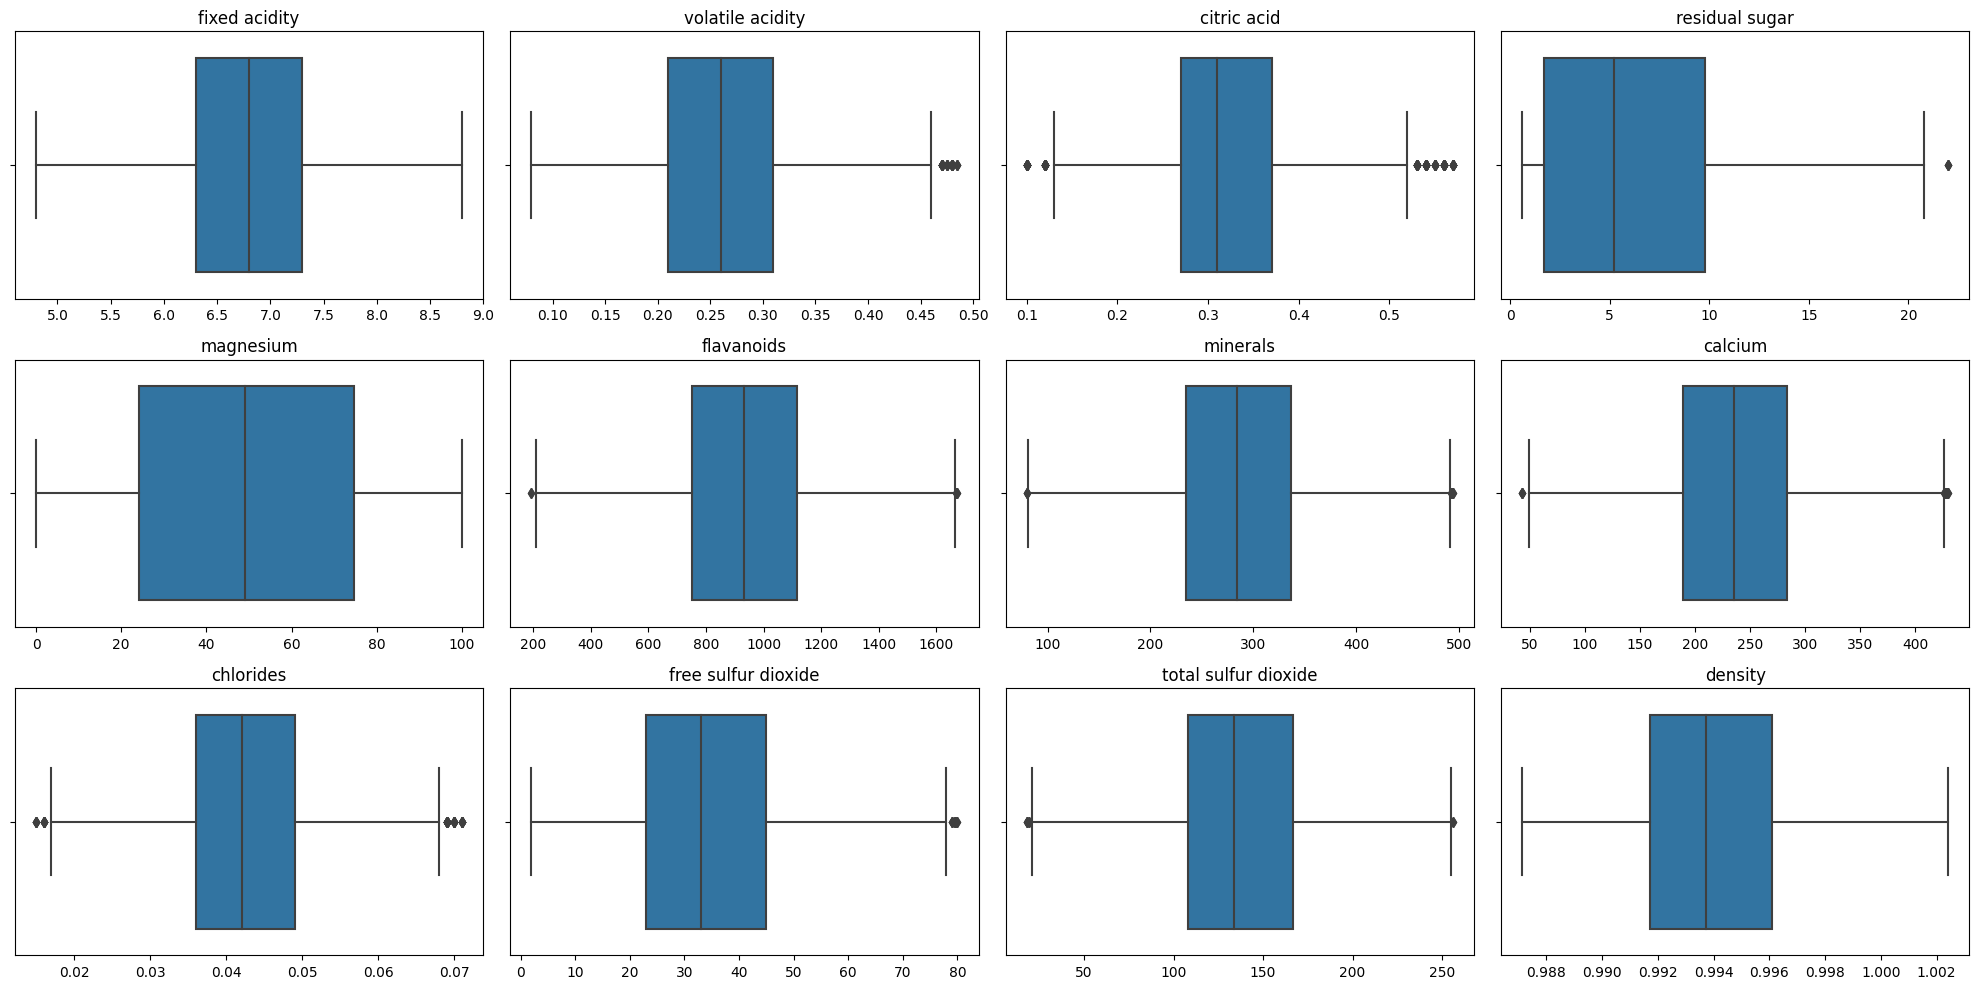

In [83]:
#plot boxplots for each numerical feature
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.boxplot(x=df_out[:,i], ax=ax)
    ax.set_title(numerical_features[i])

plt.tight_layout()
plt.show()


## Outlier Detection for Label with z-score

In [84]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np


def outlier_detection_label(df):
    #detect outliers and impute them with the simple imputer
    from sklearn.impute import KNNImputer
    print(df.shape)

    #detect outliers with z-score and set them to NaN with = np.nan
    from scipy import stats
    z = np.abs(stats.zscore(df.iloc[:, df.shape[1]-1]))
    print('Detected Outliers ')
    print(df.iloc[:, df.shape[1]-1][(z >= 3)])
    df.iloc[:, df.shape[1]-1][(z >= 3)] = np.nan


    #impute outliers with linear regression
    imputer = KNNImputer(n_neighbors=5)
    df = imputer.fit_transform(df)

    return df

outlier_detection_label = FunctionTransformer(outlier_detection_label).set_output(transform="pandas")



C:\Users\LucaH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


## Imputer for missing values in numeric columns

In [85]:
# simpleimputer for numerical features
from sklearn.impute import SimpleImputer

categorical_imputer = SimpleImputer(strategy="most_frequent")

numerical_imputer = SimpleImputer(strategy="mean")


In [86]:
#impute missing values for numerical features
filled_numerical = numerical_imputer.fit_transform(df[numerical_features])

_________

## Scaler for numeric columns

Remember to scale the data to the range between 0 and 1 before using PCA!

In [87]:
#MinMaxScaler to normalize numerical features
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

In [88]:
#apply minmaxscaler to numerical features
scaled_numerical = scaler_minmax.fit_transform(filled_numerical)

Scales numerical features to range between 0 and 1.

In [89]:
#ALTERNATIVE StandardScaler to normalize numerical features
#from sklearn.preprocessing import StandardScaler
#scaler_std = StandardScaler()

The standard score of a sample `x` is calculated as: 

`z = (x - u) / s `

where `u` is the mean of the training samples or zero if `with_mean=False`, and `s` is the standard deviation of the training samples or one if `with_std=False`.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler


In [90]:
#filled_numerical to dataframe
scaled_numerical = pd.DataFrame(scaled_numerical, columns=numerical_features)
scaled_numerical

,fixed acidity,volatile acidity,citric acid,residual sugar,magnesium,flavanoids,minerals,calcium,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.2500,0.068627,0.398374,0.007669,0.767225,0.426144,0.304243,0.209005,0.115727,0.066202,0.206497,0.111283,0.427273,0.302326,0.193548
1,0.3500,0.166667,0.260163,0.076687,0.047624,0.567500,0.420588,0.477166,0.089021,0.045296,0.136891,0.086789,0.218182,0.348837,0.500000
2,0.3625,0.127451,0.276423,0.013804,0.851901,0.370285,0.514803,0.423268,0.077151,0.149826,0.264501,0.045516,0.472727,0.162791,0.741935
3,0.5625,0.196078,0.219512,0.259202,0.119458,0.363929,0.395104,0.435193,0.106825,0.160279,0.566125,0.250916,0.272727,0.395349,0.177419
4,0.4625,0.333333,0.154472,0.096626,0.055666,0.368106,0.141523,0.169690,0.094955,0.209059,0.327146,0.153327,0.463636,0.174419,0.322581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.3250,0.147059,0.300813,0.111963,0.927010,0.558132,0.539929,0.436132,0.121662,0.202091,0.327146,0.149470,0.127273,0.313953,0.209677
7996,0.4000,0.137255,0.211382,0.131902,0.948079,0.409342,0.545842,0.438497,0.053412,0.121951,0.262181,0.099325,0.309091,0.139535,0.725806
7997,0.4625,0.176471,0.243902,0.061350,0.500959,0.392523,0.614976,0.601658,0.053412,0.094077,0.192575,0.071745,0.390909,0.186047,0.645161
7998,0.3125,0.343137,0.260163,0.125767,0.848019,0.641560,0.557984,0.471360,0.097923,0.055749,0.225058,0.088525,0.509091,0.127907,0.790323


## PCA for numeric columns

In [91]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA


def dimenionality_reduction(df):
    #dimensionality reduction with PCA
    from sklearn.decomposition import PCA
    #we want the explained variance to be 95%. 
    #with choosing n_components=0.95,
    #PCA will return the minimum number of principal components 
    #at which 95% of the variance is retained.
    pca = PCA(n_components=0.95)
    #apply pca to numerical features
    df = pca.fit_transform(df)

    #write pca to a pickle file
    import pickle
    with open('pca.pickle', 'wb') as outfile:
        pickle.dump(pca, outfile)

    return df

dimenionality_reduction = FunctionTransformer(dimenionality_reduction)



PCA wirklich notwendig? 

________

## Pipeline Building

In [92]:
from sklearn.preprocessing import OneHotEncoder

#pipeline for categorical features
categorical_pipeline = Pipeline(steps=[])
categorical_pipeline.steps.append(('imputer', categorical_imputer))
categorical_pipeline.steps.append(('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)))

#pipeline for numerical features
numeric_pipeline = Pipeline(steps=[])
numeric_pipeline.steps.append(('imputer', numerical_imputer))
numeric_pipeline.steps.append(('outlier_detection', outlier_detection))
numeric_pipeline.steps.append(('scaler', scaler_minmax))
numeric_pipeline.steps.append(('PCA', dimenionality_reduction))

#pipeline for label
label_pipeline = Pipeline(steps=[])
label_pipeline.steps.append(('imputer', numerical_imputer))


# let pipeline know which pipeline to use for which features
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
        ('label', label_pipeline, label)
    ]).set_output(transform="pandas")

pipeline.steps.append(('preprocessor', preprocessor))

pipeline.steps.append(('outlier_detection_label', outlier_detection_label))

C:\Users\LucaH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [93]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outlier_detection',
                                                                   FunctionTransformer(func=<function outlier_detection at 0x0000016265AD63E0>)),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   FunctionTransformer(func=<function dimenionality_reduction at 0x0000016265E9CF40>))]),
                                                  Index(['fixed acidity', '...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['wine type'], dtype='object')),
                                                 ('label',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  0    quality
dtype: object)])),
                ('outlier_detection_label',
                 FunctionTransformer(func=<function outlier_detection_label at 0x0000016265F38FE0>))])

## Pipeline Test

In [94]:
end_data = pipeline.fit_transform(df)

(8000, 17)
Detected Outliers 
160     99.0
197     99.0
228     99.0
314     99.0
318     99.0
        ... 
7119    99.0
7328    99.0
7426    99.0
7721    99.0
7778    99.0
Name: 16, Length: 70, dtype: float64


In [95]:
#to dataframe
end_data = pd.DataFrame(end_data)
end_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.146686,0.123965,0.473815,-0.027085,-0.368364,-0.323989,0.027573,-0.074581,-0.020930,-0.256417,-0.317546,0.0,0.0,0.0,0.0,1.0,5.0
1,-0.295938,-0.424840,-0.089994,0.298429,0.094883,-0.142329,-0.004779,0.154212,-0.079247,0.122248,-0.265969,0.0,0.0,0.0,1.0,0.0,6.0
2,-0.444000,0.323833,0.172527,-0.044817,-0.118602,0.208257,0.264747,-0.162559,0.068712,-0.022440,0.103979,0.0,1.0,0.0,0.0,0.0,7.0
3,0.865723,-0.393676,-0.088879,0.156912,0.073227,0.138319,-0.110470,-0.045057,-0.020169,0.283855,0.184479,0.0,0.0,0.0,1.0,0.0,6.0
4,0.208919,-0.651381,0.358892,-0.151156,0.292764,0.255662,-0.039431,-0.099682,0.297068,0.018623,0.258888,0.0,0.0,0.0,1.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.338542,0.431824,0.151920,0.090996,-0.102283,0.114399,0.182303,0.105419,0.192814,0.128869,-0.377451,1.0,0.0,0.0,0.0,0.0,6.0
7996,-0.203496,0.421526,0.196535,0.160053,0.201201,0.182145,0.345382,-0.126250,-0.108546,0.188852,0.098021,1.0,0.0,0.0,0.0,0.0,8.0
7997,-0.400881,0.096578,-0.182898,0.256470,0.111856,0.124379,0.154791,-0.098464,-0.049906,0.074342,0.165029,0.0,0.0,0.0,1.0,0.0,7.0
7998,-0.335001,0.355840,0.108240,-0.017503,0.467030,0.176151,0.003206,0.211309,-0.148008,-0.310888,0.070735,0.0,1.0,0.0,0.0,0.0,7.0


In [96]:
end_data.columns

RangeIndex(start=0, stop=17, step=1)

## Regression Model Test

In [97]:
#train random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = end_data.iloc[:, :end_data.shape[1]-1]
y = end_data.iloc[:, end_data.shape[1]-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

#fit model with gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'max_depth': [5, 10, 15, 20, 25]}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

#predict
y_pred = grid.predict(X_test)

#evaluate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("R2: ", r2)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
MSE:  0.3683559698547304
R2:  0.7032960678745133


In [98]:
#train sklearn.neural_network.MLPRegressor
from sklearn.neural_network import MLPRegressor

#fit model with gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'hidden_layer_sizes': [(100,100,100), (100,100,100,100), (100,100,100,100,100)],
                'activation': ['relu', 'tanh', 'logistic'],
                'solver': ['adam'],
                'alpha': [0.0001, 0.001, 0.01, 0.1],
                'learning_rate': ['constant','adaptive'],
                'learning_rate_init': [0.001, 0.01, 0.1]}
grid = GridSearchCV(MLPRegressor(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

#predict
y_pred = grid.predict(X_test)

#evaluate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("R2: ", r2)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
MSE:  0.5384936765278336
R2:  0.5662532866956701


C:\Users\LucaH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [101]:
#show best parameters
grid.best_params_

{'activation': 'tanh',
 'alpha': 0.001,
 'hidden_layer_sizes': (100, 100, 100),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'solver': 'adam'}

In [100]:
#show best features sorted by importance
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f, indices[f], importances[indices[f]]))

    

AttributeError: 'MLPRegressor' object has no attribute 'feature_importances_'